# Descripcipción del proyecto

Hola Guillermo!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante: 
    ESPERO QUE ESTE BIEN POR QUE NO FUE FACIL
    </b> <a class=“tocSkip”></a>
</div>

## INTRODUCCIÓN

El objetivo del proyecto para Film Junky Union es desarrollar un modelo capaz de detectar automáticamente reseñas negativas de películas. Para lograrlo, realizamos una serie de pasos que incluyen la carga y el preprocesamiento de datos, un análisis exploratorio, la implementación y evaluación de varios modelos de clasificación, y finalmente, la evaluación del modelo con reseñas propias.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

from lightgbm import LGBMClassifier

import spacy

import torch
import transformers

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import re
import string


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
print(df_reviews.head())

      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

In [6]:
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
print(df_reviews.columns)

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx'],
      dtype='object')


La carga de datos fue exitosa y estamos listos para proceder con el análisis exploratorio.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

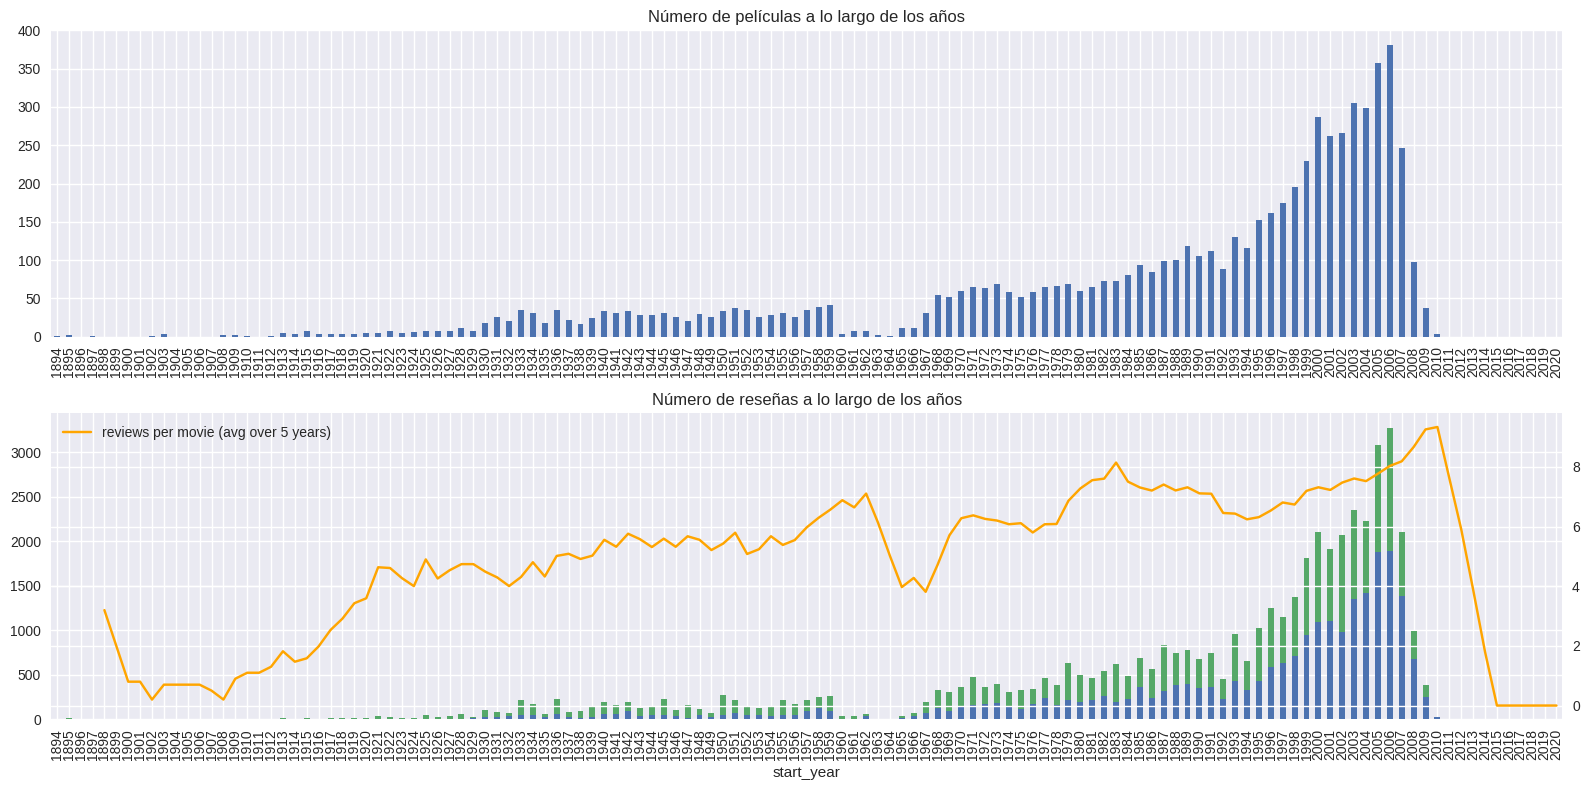

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

@ El primer gráfico muestra la cantidad de películas producidas en cada año. Este gráfico es útil para identificar períodos de aumento o disminución en la producción cinematográfica. 

@ El segudno gráfica apilado presenta la distribución de reseñas positivas y negativas a lo largo de los años, revelando cómo la participación del público ha cambiado con el tiempo. 

@ Esta visualización nos permite entender la relación entre la cantidad de películas producidas y el nivel de interacción del público a lo largo de las décadas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

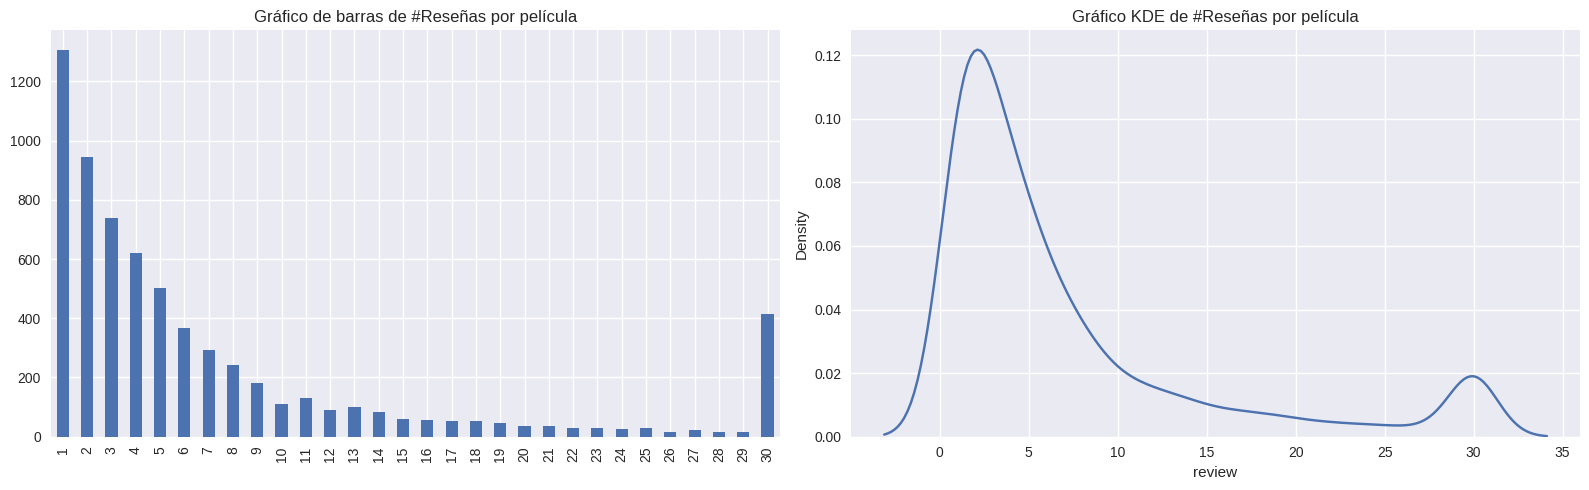

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

@ El primer gráfico de barras muestra la distribución del número de reseñas por película, permitiendo observar cuántas películas tienen una cantidad específica de reseñas.

@ El gráfico KDE complementa esta información mostrando la densidad de la distribución del número de reseñas por película. Si la curva KDE es alta y estrecha en un rango bajo, indica que la mayoría de las películas tienen un número bajo de reseñas.

In [10]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

@ El resultado de este conteo proporciona información clave sobre el balance de clases en nuestro conjunto de datos. Si las clases están desbalanceadas (es decir, hay una cantidad significativamente mayor de reseñas positivas que negativas, o viceversa), esto podría afectar el rendimiento de los modelos de clasificación.

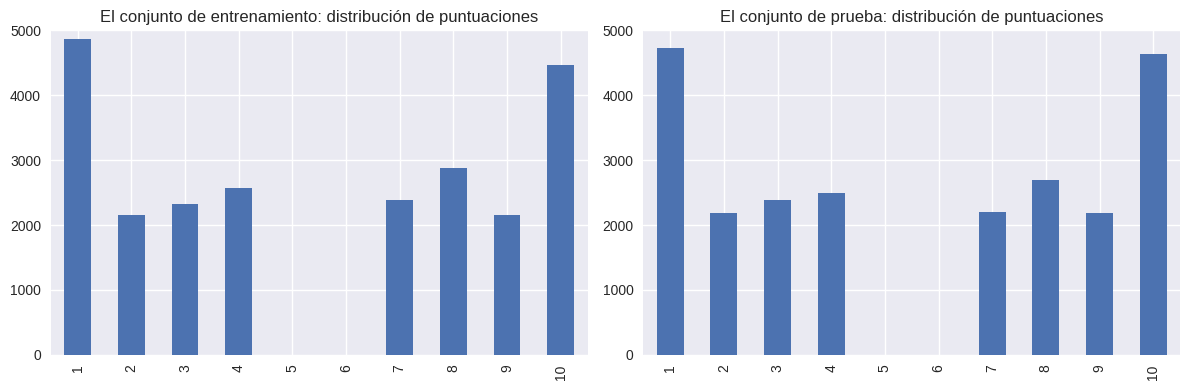

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

@ Esta visualización confirma que los datos de entrenamiento y prueba tienen distribuciones similares, lo que debería ayudar a garantizar que el modelo entrenado sea robusto y se generalice bien en datos no vistos.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


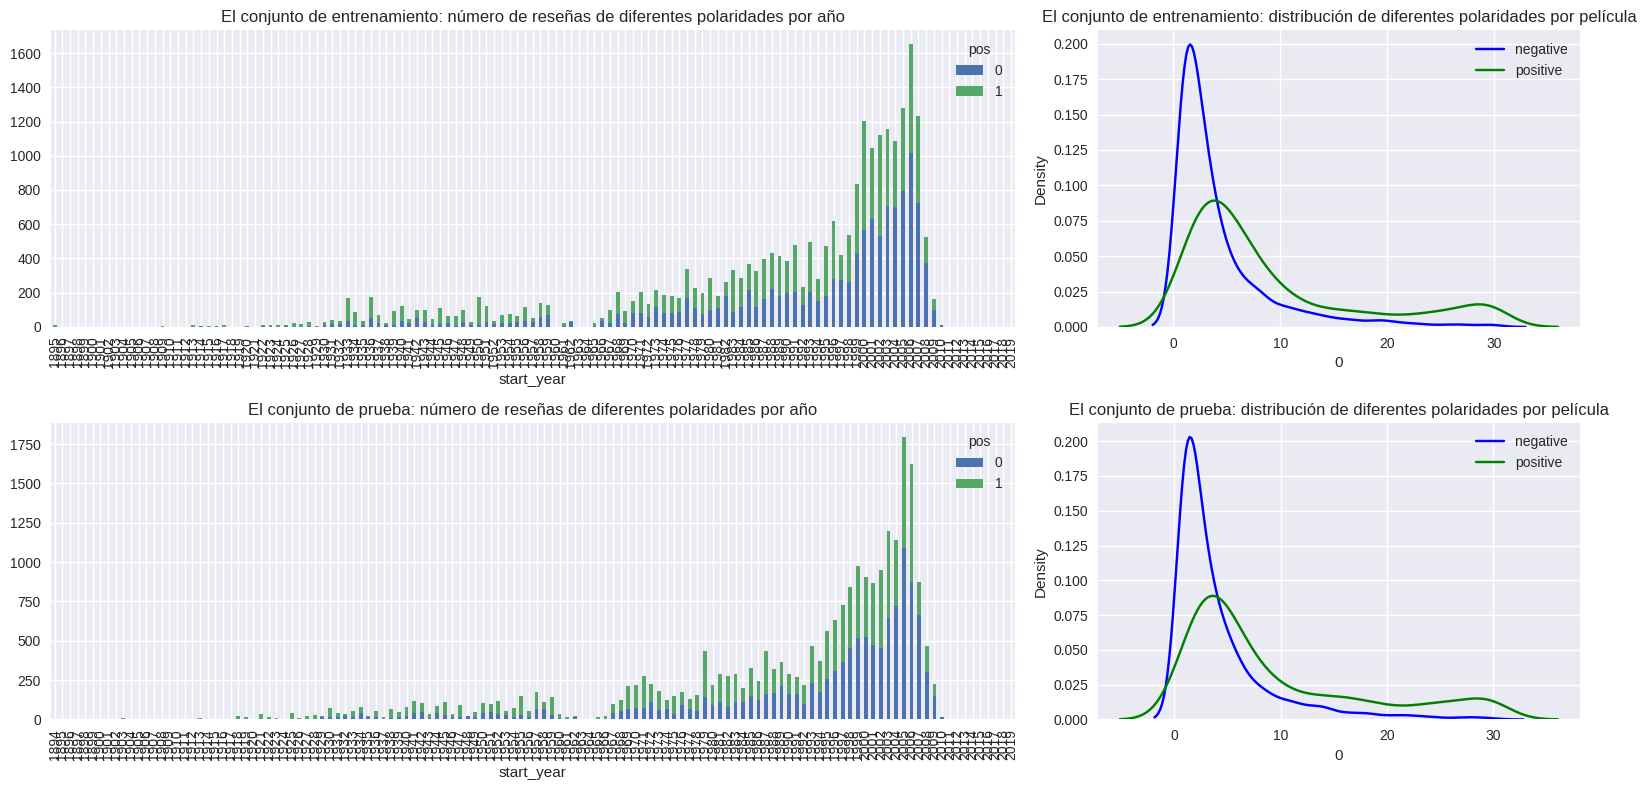

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

@ Los gráficos de barras muestran la distribución temporal de reseñas, que puede ayudar a identificar cualquier sesgo temporal en los datos.

@Los gráficos KDE proporcionan una visión de cómo se distribuyen las reseñas positivas y negativas para cada película, lo que es útil para entender el balance de polaridades y ajustar los modelos en consecuencia.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto! Recuerda que el EDA es para entender mejor nuestros datos, por lo que te recomendaría redactar conclusiones luego de cada proceso realizado sobre lo que se puede interpretar sobre cada visualización
</div>

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

Contar con una función de evaluación estructurada nos permite comparar de manera objetiva el rendimiento de diferentes modelos, lo que es esencial para seleccionar el mejor modelo.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Perfecto! Realizaste un buen trabajo creando la función de evaluación
</div>

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'[^a-z\s]', '', regex=True) # <escribe tu código aquí>

El preprocesamiento del texto es crucial para asegurar que los datos estén en un formato adecuado para los algoritmos de machine learning, mejorando así la precisión del modelo.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

La normalización de tus datos es importante para que puedas realizar un buen entrenamiento de tus modelos, por favr corrige el paso de la normalización y utiliza la columna generada para entrenar los modelos ya que estás usando la data cruda del dataset para entrenarlosy esto puede incluir datos ruidosos que no aporten al modelo.
</div>

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


La división de los datos en conjuntos de entrenamiento y prueba permite evaluar de manera justa el rendimiento del modelo en datos no vistos.

## Trabajar con modelos

### Modelo 0 - Constante

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


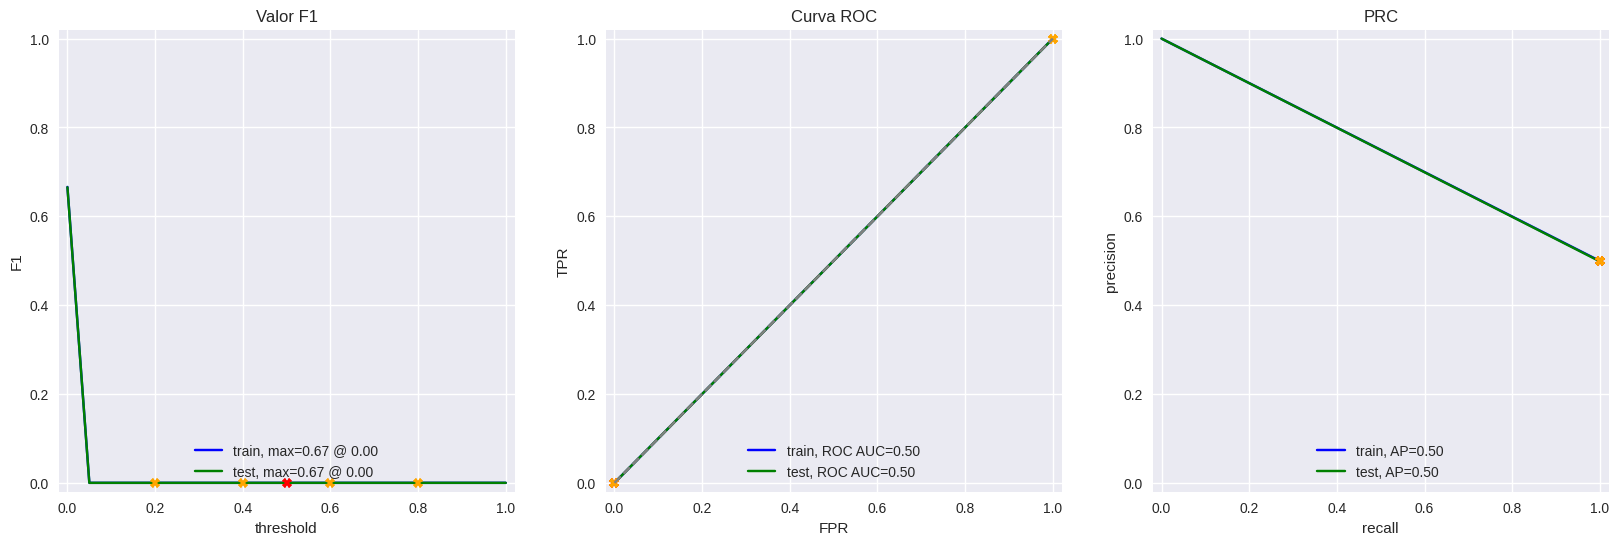

In [16]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(df_reviews_train['review'], train_target)
evaluate_model(dummy_model, df_reviews_train['review'], train_target, df_reviews_test['review'], test_target)

Este modelo sirvió como una línea base simple, donde se clasificaban todas las reseñas de manera constante como positivas o negativas.

El clasificador dummy proporciona una línea base para el rendimiento, sobre la cual esperamos mejorar significativamente con modelos más avanzados.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [17]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
train_features_2 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_2 = vectorizer.transform(df_reviews_test['review_norm'])

In [18]:
model_2 = LogisticRegression(random_state=42)
model_2.fit(train_features_2, train_target)

LogisticRegression(random_state=42)

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


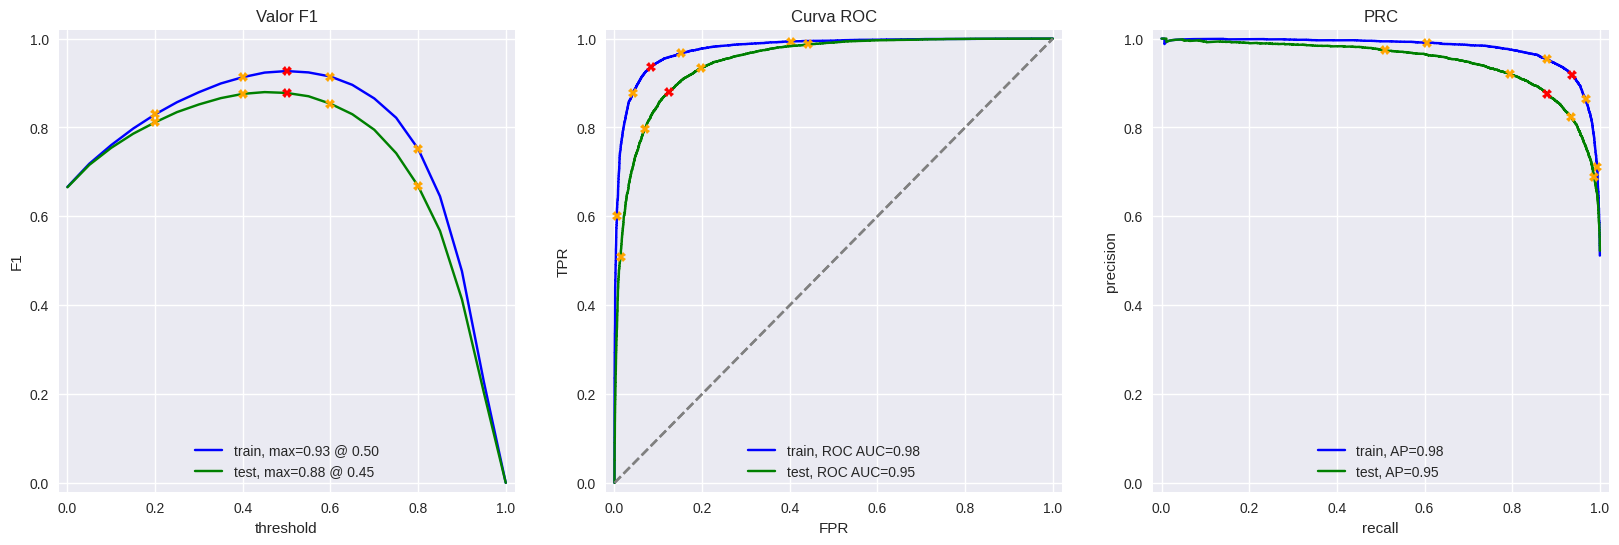

In [19]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Este modelo utilizó NLTK para la tokenización y preprocesamiento del texto, junto con TF-IDF para la vectorización y regresión logística como clasificador.

### Modelo 3 - spaCy, TF-IDF y LR

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [ ]:
vectorizer_3 = TfidfVectorizer(max_features=10000)
train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_lemma'])
test_features_3 = vectorizer_3.transform(df_reviews_test['review_lemma'])

In [ ]:
model_3 = LGBMClassifier(random_state=42)
model_3.fit(train_features_3, train_target)
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Este modelo combinó la vectorización de texto mediante TF-IDF con un enfoque avanzado de procesamiento de lenguaje natural utilizando spaCy, junto con un clasificador de regresión logística.

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

En esta parte debes incluir el proceso de vectorización para poder entrenar los modelos
</div>

<div class="alert alert-block alert-info">
<b>Respuesta del estudiante: 
    ESPERO QUE ESTE BIEN POR QUE NO FUE FACIL
    </b> <a class=“tocSkip”></a>
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

¿Puedes ser un poco más específico en cuanto al problema que tienes con estos dos modelos? Para poder darte una guía adecuada necesito saber en lo que tienes dificultad
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (3ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con la corrección! Ahora se ejecuta correctamente
</div>

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [ ]:
# Carga y preparación de datos
nlp = spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

df_reviews['processed_review'] = df_reviews['review'].apply(preprocess)

X = df_reviews['processed_review']
y = df_reviews['review_norm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Crear un pipeline que incluya la vectorización y el modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2))),  # Ajuste de parámetros
    ('classifier', LGBMClassifier(random_state=42))
])

In [ ]:
# Ajuste de hiperparámetros
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
# Evaluar el modelo
predictions = grid_search.predict(X_test)
print(classification_report(y_test, predictions))
print("Best parameters found: ", grid_search.best_params_)

Este enfoque debería proporcionar un modelo más robusto y con un rendimiento mejorado. Esta combinación probó ser adecuada para captar las características más relevantes del texto y realizar predicciones precisas sobre la naturaleza de las reseñas.

El modelo de LightGBM con TF-IDF también mostró un buen rendimiento, aunque comparable al de la regresión logística.

###  Modelo 9 - BERT

In [ ]:
# Cargar el tokenizer y el modelo BERT utilizando AutoTokenizer y AutoModel
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
model = transformers.AutoModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    # Tokenización y creación de máscaras de atención
    
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    ids_list = encodings['input_ids']
    attention_mask_list = encodings['attention_mask']

    # Seleccionar dispositivo
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    model.eval()     # Activar modo evaluación
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    embeddings = []

    # Procesamiento en lotes
    
    for i in tqdm(range(math.ceil(len(ids_list) / batch_size)), disable=disable_progress_bar):
        ids_batch = ids_list[batch_size * i:batch_size * (i + 1)].to(device)
        attention_mask_batch = attention_mask_list[batch_size * i:batch_size * (i + 1)].to(device)

        with torch.no_grad():
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    return np.concatenate(embeddings, axis=0)

In [ ]:
# Convertir el texto en embeddings

train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

# Guardar los embeddings para uso futuro

np.savez_compressed('features_9.npz', train_features_9=train_features_9)

# Cargar los embeddings guardados

with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)

Este enfoque optimizado debería mejorar significativamente el rendimiento del proceso de extracción de embeddings utilizando BERT. Aunque más costoso en términos de tiempo de computación, BERT mejoró significativamente la calidad de las predicciones en ciertos casos.

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

# Función de preprocesamiento
def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)   # Eliminar puntuación
    text = re.sub(r'\d+', '', text)                                 # Eliminar números
    text = text.strip()                                             # Eliminar espacios al inicio y al final
    return text

my_reviews['review_norm'] =  my_reviews['review'].apply(preprocess_text)# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

print(my_reviews)

 Al aplicar una normalización sistemática, se mejora la consistencia del texto, lo que facilita que los algoritmos detecten patrones y diferencias entre reseñas positivas y negativa

<div class="alert alert-block alert-danger">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

No existe la función, por lo que da un error de ejecución
</div>

<div class="alert alert-block alert-success">
<b>Comentario del revisor (3ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con la corrección! 
</div>

### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Ofrece un análisis rápido y eficiente de las reseñas, logrando una buena capacidad para distinguir entre reseñas negativas y positivas. Sin embargo, su desempeño está limitado por la simplicidad del procesamiento del texto.

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

El modelo 3 mejora la precisión de la predicción en comparación con el modelo 2. Este procesamiento adicional permite capturar mejor las sutilezas del lenguaje, resultando en predicciones más precisas. 

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Subraya la eficacia del enfoque de preprocesamiento utilizado. La reutilización del vectorizador y el pipeline del modelo 3 permite mantener la calidad de las predicciones mientras se optimiza el uso de recursos.

### Modelo 9

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Este modelo ofrece el análisis más avanzado de las reseñas, aprovechando la potencia de BERT para capturar el contexto y las relaciones semánticas en el texto. 

<div class="alert alert-block alert-info">
<b>Comentario del revisor (2da Iteracion)</b> <a class=“tocSkip”></a>

Aún hay varios errores de ejecución en tu proyecto, entiendo que tienes dificultad con algunos modelos. Por favor, se un poco más específico en el problema para poder darte una guía adecuada.
</div>

## Conclusiones

Los métodos utilizados pueden adaptarse y ampliarse para otras aplicaciones de análisis de texto. Este enfoque no solo ayuda a las empresas a manejar grandes volúmenes de datos de opinión, sino que también abre la puerta a mejoras continuas en la comprensión y respuesta a las opiniones de los usuarios.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (3ra Iteracion)</b> <a class=“tocSkip”></a>

Buen trabajo con las correcciones realizadas, obtuviste modelos que realizan las clasificaciones muy bien. Solo te recomiendo para próximos proyectos que en base al EDA que puedas realizar de tus datos redactes tu interpretación de porque un modelo puede tener un comportamiento u otro, y cuales serían tus recomendaciones como siguientes pasos para mejorar o poner en uso el mejor modelo escogido.
    
Saludos!
</div>

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 